In [4]:
#stock data from yfinance
stocks=['GOOGL','MSFT','AAPL','TSLA','META','NFLX','SSL','CL=F']

In [5]:
start_date='2022-01-01'
end_date='2023-06-01'
df=yf.download(stocks, start=start_date,end=end_date)['Adj Close']

[*********************100%%**********************]  8 of 8 completed


**Identifying Cointegrated Pairs**

In [6]:

#get all pairs of stocks
from itertools import combinations
stock_pairs=list(combinations(df.columns,2))
stock_pairs

[('AAPL', 'CL=F'),
 ('AAPL', 'GOOGL'),
 ('AAPL', 'META'),
 ('AAPL', 'MSFT'),
 ('AAPL', 'NFLX'),
 ('AAPL', 'SSL'),
 ('AAPL', 'TSLA'),
 ('CL=F', 'GOOGL'),
 ('CL=F', 'META'),
 ('CL=F', 'MSFT'),
 ('CL=F', 'NFLX'),
 ('CL=F', 'SSL'),
 ('CL=F', 'TSLA'),
 ('GOOGL', 'META'),
 ('GOOGL', 'MSFT'),
 ('GOOGL', 'NFLX'),
 ('GOOGL', 'SSL'),
 ('GOOGL', 'TSLA'),
 ('META', 'MSFT'),
 ('META', 'NFLX'),
 ('META', 'SSL'),
 ('META', 'TSLA'),
 ('MSFT', 'NFLX'),
 ('MSFT', 'SSL'),
 ('MSFT', 'TSLA'),
 ('NFLX', 'SSL'),
 ('NFLX', 'TSLA'),
 ('SSL', 'TSLA')]

**Testing Pairwise Cointegration**

In [7]:
from statsmodels.tsa.stattools import coint
threshold=0.1
#run Engle-Granger test for cointegration on each pair of stocks
for pair in stock_pairs:
    #subset df based on current pair of stocks
    df2=df[list(pair)]
    #perform test for the current pair of stocks
    score,pvalue,_=coint(df2.values[:,0],df2.values[:,1])
    #check if the current pair of stocks is cointegrated
    if pvalue<threshold:
        print(pair, 'are cointegrated')
    else:
        print(pair,'are not cointegrated')

('AAPL', 'CL=F') are not cointegrated
('AAPL', 'GOOGL') are not cointegrated
('AAPL', 'META') are not cointegrated
('AAPL', 'MSFT') are cointegrated
('AAPL', 'NFLX') are not cointegrated
('AAPL', 'SSL') are not cointegrated
('AAPL', 'TSLA') are not cointegrated
('CL=F', 'GOOGL') are not cointegrated
('CL=F', 'META') are not cointegrated
('CL=F', 'MSFT') are not cointegrated
('CL=F', 'NFLX') are not cointegrated
('CL=F', 'SSL') are cointegrated
('CL=F', 'TSLA') are not cointegrated
('GOOGL', 'META') are not cointegrated
('GOOGL', 'MSFT') are not cointegrated
('GOOGL', 'NFLX') are not cointegrated
('GOOGL', 'SSL') are not cointegrated
('GOOGL', 'TSLA') are not cointegrated
('META', 'MSFT') are cointegrated
('META', 'NFLX') are not cointegrated
('META', 'SSL') are not cointegrated
('META', 'TSLA') are not cointegrated
('MSFT', 'NFLX') are not cointegrated
('MSFT', 'SSL') are not cointegrated
('MSFT', 'TSLA') are not cointegrated
('NFLX', 'SSL') are cointegrated
('NFLX', 'TSLA') are not co

In [1]:
import os
import math
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
%matplotlib inline

SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [24]:
class QTS_OPTIMIZER(nn.Module):
    def __init__(self,tickers,start_date,end_date,riskfree_rate=0.04):
        super(QTS_OPTIMIZER,self).__init__()
        self.tickers=tickers
        self.start=start_date
        self.end=end_date
        self.riskfree_rate=riskfree_rate
        self.stock=self.get_stock()
        
    def get_stock(self):
        print('=====Starting Download=====')
        stock_df=yf.download(self.tickers,self.start,self.end)['Adj Close']
        print('=====Download Complete=====')
        return pd.DataFrame(stock_df)
    
    def forward(self,entry_threshold, exit_threshold, window=10):
        #add SMA columns
        stock_df=self.stock.copy()
        #calculate the spread for SSLnd CL=F
        Y=stock_df[self.tickers[0]]
        X=stock_df[self.tickers[1]]
        #estimate linear regression coefficients
        X_with_con=sm.add_constant(X)
        model=OLS(Y,X_with_con).fit()
        #obtain the spread as residuals
        spread= Y - model.predict()
        spread_mean=spread.rolling(window=window).mean()
        spread_std=spread.rolling(window=window).std()
        #calculate Z-score
        zscore=(spread-spread_mean)/spread_std
        #remove initial NA values
        first_valid_idx=zscore.first_valid_index()
        zscore=zscore[first_valid_idx:]
        
        #initialise stock positions
        stock1_pos=pd.Series(data=0, index=zscore.index)
        stock2_pos=pd.Series(data=0, index=zscore.index)
        
        #generate daily entry and exit signals for each stock
        for i in range(1,len(zscore)):
            if zscore[i]<entry_threshold and stock1_pos[i-1]==0:
                stock1_pos[i]=1 # long stock1
                stock2_pos[i]=-1 # short stock 2
            
            elif zscore[i]>entry_threshold and stock2_pos[i-1]==0:
                stock1_pos[i]=-1
                stock2_pos[i]=1
                
            elif abs(zscore[i])<exit_threshold:
                stock1_pos[i]=0
                stock2_pos[i]=0
            #else maintain positions
            else:
                stock1_pos[i]=stock1_pos[i-1]
                stock2_pos[i]=stock2_pos[i-1]
                
        #calculate returns
        stock1_returns=(Y[first_valid_idx:].pct_change()*stock1_pos.shift(1)).fillna(0)
        stock2_returns=(X[first_valid_idx:].pct_change()*stock2_pos.shift(1)).fillna(0)
        
        #total, annual returns and volatility
        total_returns=stock1_returns + stock2_returns
        ret_annual=(1+total_returns).prod()**(252/Y[first_valid_idx:].shape[0])-1
        vol_annual=total_returns.std()*(252**0.5)
        if vol_annual==0:
            vol_annual=100
            
        #alculate_sharpe_ratio
        sharpe_ratio=(ret_annual-self.riskfree_rate)/vol_annual
        return sharpe_ratio


In [25]:
qts= QTS_OPTIMIZER(tickers=['SSL','CL=F'],start_date='2022-01-01',end_date='2023-06-01')

=====Starting Download=====
[*********************100%%**********************]  2 of 2 completed
=====Download Complete=====


In [26]:
qts.stock.head()

,CL=F,SSL
Date,,
2022-01-03,76.080002,14.948917
2022-01-04,76.989998,14.682291
2022-01-05,77.849998,14.415663
2022-01-06,79.459999,14.691179
2022-01-07,78.900002,14.931142


In [27]:
qts(entry_threshold=2, exit_threshold=1)

-0.09482143984661498

In [28]:
qts(entry_threshold=1.5, exit_threshold=0.5)

0.3331286751667144

In [41]:
qts(entry_threshold=0.9, exit_threshold=0.5)

0.3778068690748699

**Bayesian Optimization**

In [47]:
def generate_initial_data(n=10):
    # generate random initial locations
    train_x1 = x1_bound[0] + (x1_bound[1] - x1_bound[0])* torch.rand(size=(n,1), device=device, dtype=dtype)
    train_x2 = torch.rand(size=(n,1), device=device,dtype=dtype)
    train_x = torch.cat((train_x1, train_x2), 1)
    # obtain the exact value of the objective functionand add output dimension
    train_y = []
    for i in range(len(train_x)):
        train_y.append(qts(entry_threshold=train_x1[i],exit_threshold=train_x2[i]))
    train_y = torch.Tensor(train_y,device=device).to(dtype).unsqueeze(-1)
    # get the current best observed value, i.e., utilityof the available dataset
    best_observed_value = train_y.max().item()
    return train_x, train_y, best_observed_value

In [48]:
train_x, train_y, best_observed_value =generate_initial_data(n=3)

In [49]:
>>> print(train_x)
>>> print(train_y)
>>> print(best_observed_value)


tensor([[2.6850, 0.6124],
        [2.7410, 0.0881],
        [1.7551, 0.7012]], dtype=torch.float64)
tensor([[ 0.3693],
        [-0.5887],
        [ 0.3242]], dtype=torch.float64)
0.3692604899406433


**Implementing the Gaussian Process Model**


In [51]:
# initialize GP model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

def initialize_model(train_x, train_y):
    # create a single-task exact GP model instance
    # use a GP prior with Matern kernel and constant mean function by default
    model = SingleTaskGP(train_X=train_x,train_Y=train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood,model)
    return mll, model

mll, model=initialize_model(train_x, train_y)
list(model.named_hyperparameters())

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([2.0000], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0., 0.]], dtype=torch.float64, requires_grad=True))]

In [52]:
# optimize GP hyperparameters
from botorch.fit import fit_gpytorch_mll
# fit hyperparameters (kernel parameters and noisevariance) of a GPyTorch model
fit_gpytorch_mll(mll.cpu());
mll = mll.to(train_x)
model = model.to(train_x)
list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([0.1444], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(0.0454, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(-0.0410, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.9174, -0.9822]], dtype=torch.float64, requires_grad=True))]

In [60]:
import time

In [53]:
# define acquisition function
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient

# call helper functions to generate initial training data and initialize model
train_x, train_y, best_observed_value =generate_initial_data(n=3)
train_x_ei = train_x
train_x_qei = train_x
train_x_ucb = train_x
train_x_qkg = train_x
train_y_ei = train_y
train_y_qei = train_y
train_y_ucb = train_y
train_y_qkg = train_y

mll_ei, model_ei = initialize_model(train_x_ei,train_y_ei)
mll_qei, model_qei = initialize_model(train_x_qei,train_y_qei)
mll_ucb, model_ucb = initialize_model(train_x_ucb,train_y_ucb)
mll_qkg, model_qkg = initialize_model(train_x_qkg,train_y_qkg)

EI = ExpectedImprovement(model=model_ei,best_f=best_observed_value)
qEI = qExpectedImprovement(model=model_qei,best_f=best_observed_value)

beta = 0.8
UCB = UpperConfidenceBound(model=model_ucb, beta=beta)

num_fantasies = 64

qKG = qKnowledgeGradient(model=model_qkg,num_fantasies=num_fantasies,X_baseline=train_x,q=1)

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [58]:
# optimize and get new observation
from botorch.optim import optimize_acqf
# get search bounds
bounds = torch.tensor([[x1_bound[0], x2_bound[0]],[x1_bound[1], x2_bound[1]]], device=device, dtype=dtype)
# parallel candidate locations generated in eachiteration
BATCH_SIZE = 1
# number of starting points for multistart optimization
NUM_RESTARTS = 10
# number of samples for initialization
RAW_SAMPLES = 1024
def optimize_acqf_and_get_observation(acq_func):
    
    """
    Optimizes the acquisition function, and returns a new candidate and a noisy observation.
    """
    # optimize
    candidates, value = optimize_acqf(acq_function=acq_func,bounds=bounds,
                        q=BATCH_SIZE,
                        num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES, # used for intialization heuristic
                                     )
    # observe new values
    new_x = candidates.detach()
    # sample output value
    new_y = qts(entry_threshold=new_x.squeeze()[0].item(), exit_threshold=new_x.squeeze()[1].item())
    # add output dimension
    new_y = torch.Tensor([new_y],device=device).to(dtype).unsqueeze(-1)
    # print("new fn value:", new_y)
    return new_x, new_y

In [59]:
def update_random_observations(best_random):
    """Simulates a random policy by drawing a new random
        points,
        observing their values, and updating the currentbest candidate to the running list.
    """
    new_x1 = x1_bound[0] + (x1_bound[1] - x1_bound[0]) *torch.rand(size=(1,1), device=device, dtype=dtype)
    new_x2 = torch.rand(size=(1,1), device=device,dtype=dtype)
    new_x = torch.cat((new_x1, new_x2), 1)
    new_y = qts(entry_threshold=new_x[0,0].item(),exit_threshold=new_x[0,1].item())
    best_random.append(max(best_random[-1], new_y))
    return best_random

In [61]:
# multiple trials
# number of runs to assess std of different BO loops
N_TRIALS = 4
# indicator to print diagnostics
verbose = True
# number of steps in the outer BO loop
N_ROUND = 20
best_random_all, best_observed_ei_all,best_observed_qei_all, best_observed_ucb_all,best_observed_qkg_all = [], [], [], [], []
# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    best_random, best_observed_ei, best_observed_qei,best_observed_ucb, best_observed_qkg = [], [], [], [], []
    # call helper functions to generate initial training data and initialize model
    train_x, train_y, best_observed_value =generate_initial_data(n=3)
    train_x_ei = train_x
    train_x_qei = train_x
    train_x_ucb = train_x
    train_x_qkg = train_x
    train_y_ei = train_y
    train_y_qei = train_y
    train_y_ucb = train_y
    train_y_qkg = train_y
    
    mll_ei, model_ei = initialize_model(train_x_ei,train_y_ei)
    mll_qei, model_qei = initialize_model(train_x_qei,train_y_qei)
    mll_ucb, model_ucb = initialize_model(train_x_ucb,train_y_ucb)
    mll_qkg, model_qkg = initialize_model(train_x_qkg,train_y_qkg)

    best_random.append(best_observed_value)
    best_observed_ei.append(best_observed_value)
    best_observed_qei.append(best_observed_value)
    best_observed_ucb.append(best_observed_value)
    best_observed_qkg.append(best_observed_value)
    
    # run N_ROUND rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ROUND + 1):
        t0 = time.monotonic()
        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_qei)
        fit_gpytorch_mll(mll_ucb)
        fit_gpytorch_mll(mll_qkg)
        
        # for best_f, we use the best observed exactvalues
        EI = ExpectedImprovement(model=model_ei,best_f=train_y_ei.max())
        qEI = qExpectedImprovement(model=model_qei,best_f=train_y_ei.max(),num_samples=1024)
        UCB = UpperConfidenceBound(model=model_ucb,beta=beta)
        qKG = qKnowledgeGradient(model=model_qkg,num_fantasies=64,objective=None,X_baseline=train_x_qkg,)
    
        # optimize and get new observation
        new_x_ei, new_y_ei =optimize_acqf_and_get_observation(EI)
        new_x_qei, new_y_qei =optimize_acqf_and_get_observation(qEI)
        new_x_ucb, new_y_ucb =optimize_acqf_and_get_observation(UCB)
        new_x_qkg, new_y_qkg =optimize_acqf_and_get_observation(qKG)

        # update training points

        train_x_ei = torch.cat([train_x_ei, new_x_ei],
dim=0)

        train_x_qei = torch.cat([train_x_qei, new_x_qei],
dim=0)

        train_x_ucb = torch.cat([train_x_ucb, new_x_ucb],
dim=0)

        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg],
dim=0)

        train_y_ei = torch.cat([train_y_ei, new_y_ei],
dim=0)

        train_y_qei = torch.cat([train_y_qei, new_y_qei],
dim=0)

        train_y_ucb = torch.cat([train_y_ucb, new_y_ucb],
dim=0)

        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg],
dim=0)
        # update progress

        best_random =update_random_observations(best_random)

        best_value_ei = max(best_observed_ei[-1],new_y_ei.item())

        best_value_qei = max(best_observed_qei[-1],new_y_qei.item())

        best_value_ucb = max(best_observed_ucb[-1],new_y_ucb.item())

        best_value_qkg = max(best_observed_qkg[-1],new_y_qkg.item())

        best_observed_ei.append(best_value_ei)

        best_observed_qei.append(best_value_qei)

        best_observed_ucb.append(best_value_ucb)

        best_observed_qkg.append(best_value_qkg)

        # reinitialize the models so they are ready for fitting on next iteration
        mll_ei, model_ei = initialize_model(train_x_ei,train_y_ei)
        mll_qei, model_qei = initialize_model(train_x_qei,train_y_qei)
        mll_ucb, model_ucb = initialize_model(train_x_ucb,train_y_ucb)
        mll_qkg, model_qkg = initialize_model(train_x_qkg,train_y_qkg)

        t1 = time.monotonic()
    best_observed_ei_all.append(best_observed_ei)
    best_observed_qei_all.append(best_observed_qei)
    best_observed_ucb_all.append(best_observed_ucb)
    best_observed_qkg_all.append(best_observed_qkg)
    best_random_all.append(best_random)


C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\Torch\lib\s

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch

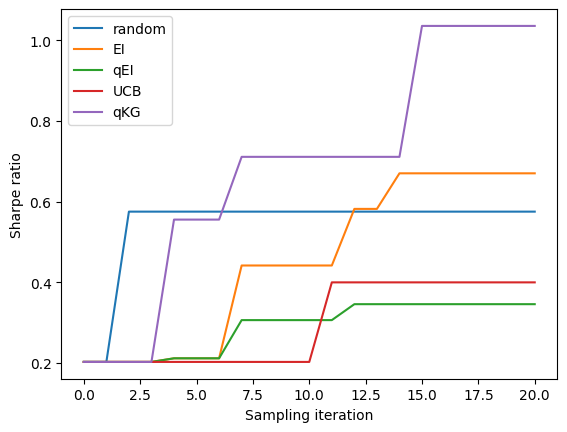

In [62]:
iters = np.arange(N_ROUND + 1) * BATCH_SIZE
plt.plot(iters, best_random, label='random')
plt.plot(iters, best_observed_ei, label='EI')
plt.plot(iters, best_observed_qei, label='qEI')
plt.plot(iters, best_observed_ucb, label='UCB')
plt.plot(iters, best_observed_qkg, label='qKG')
plt.legend()
plt.xlabel("Sampling iteration")
plt.ylabel("Sharpe ratio")
plt.show()

In [63]:
def extract_last_entry(x):
    tmp = []
    for i in range(4):
        tmp.append(x[i][-1])
    return tmp

rst_df = pd.DataFrame({
"EI":
[np.mean(extract_last_entry(best_observed_ei_all)),
np.std(extract_last_entry(best_observed_ei_all))],
"qEI":
[np.mean(extract_last_entry(best_observed_qei_all)),
np.std(extract_last_entry(best_observed_qei_all))],
"UCB":
[np.mean(extract_last_entry(best_observed_ucb_all)),
np.std(extract_last_entry(best_observed_ucb_all))],
"qKG":
[np.mean(extract_last_entry(best_observed_qkg_all)),
np.std(extract_last_entry(best_observed_qkg_all))],
"random":
[np.mean(extract_last_entry(best_random_all)),
np.std(extract_last_entry(best_random_all))],
}, index=["mean", "std"])

In [64]:
rst_df

,EI,qEI,UCB,qKG,random
mean,0.820025,0.643667,0.757313,0.862672,0.519601
std,0.122292,0.188106,0.343575,0.118941,0.137078
